# Finding Lanes 

## Importing important libraries

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## defining of named constants 

In [17]:
calib_directory = "camera_cal"
calib_file = "camera_calibration.npy"
test_img = "test_images"
input_vid = "input_videos"
out_vid = "output_videos"

y_pixel_dist = 30. / 720. # meters per pixel in y dimension
x_pixel_dist = 3.7 / 700. # meters per pixel in x dimension

# Caliberation of the camera

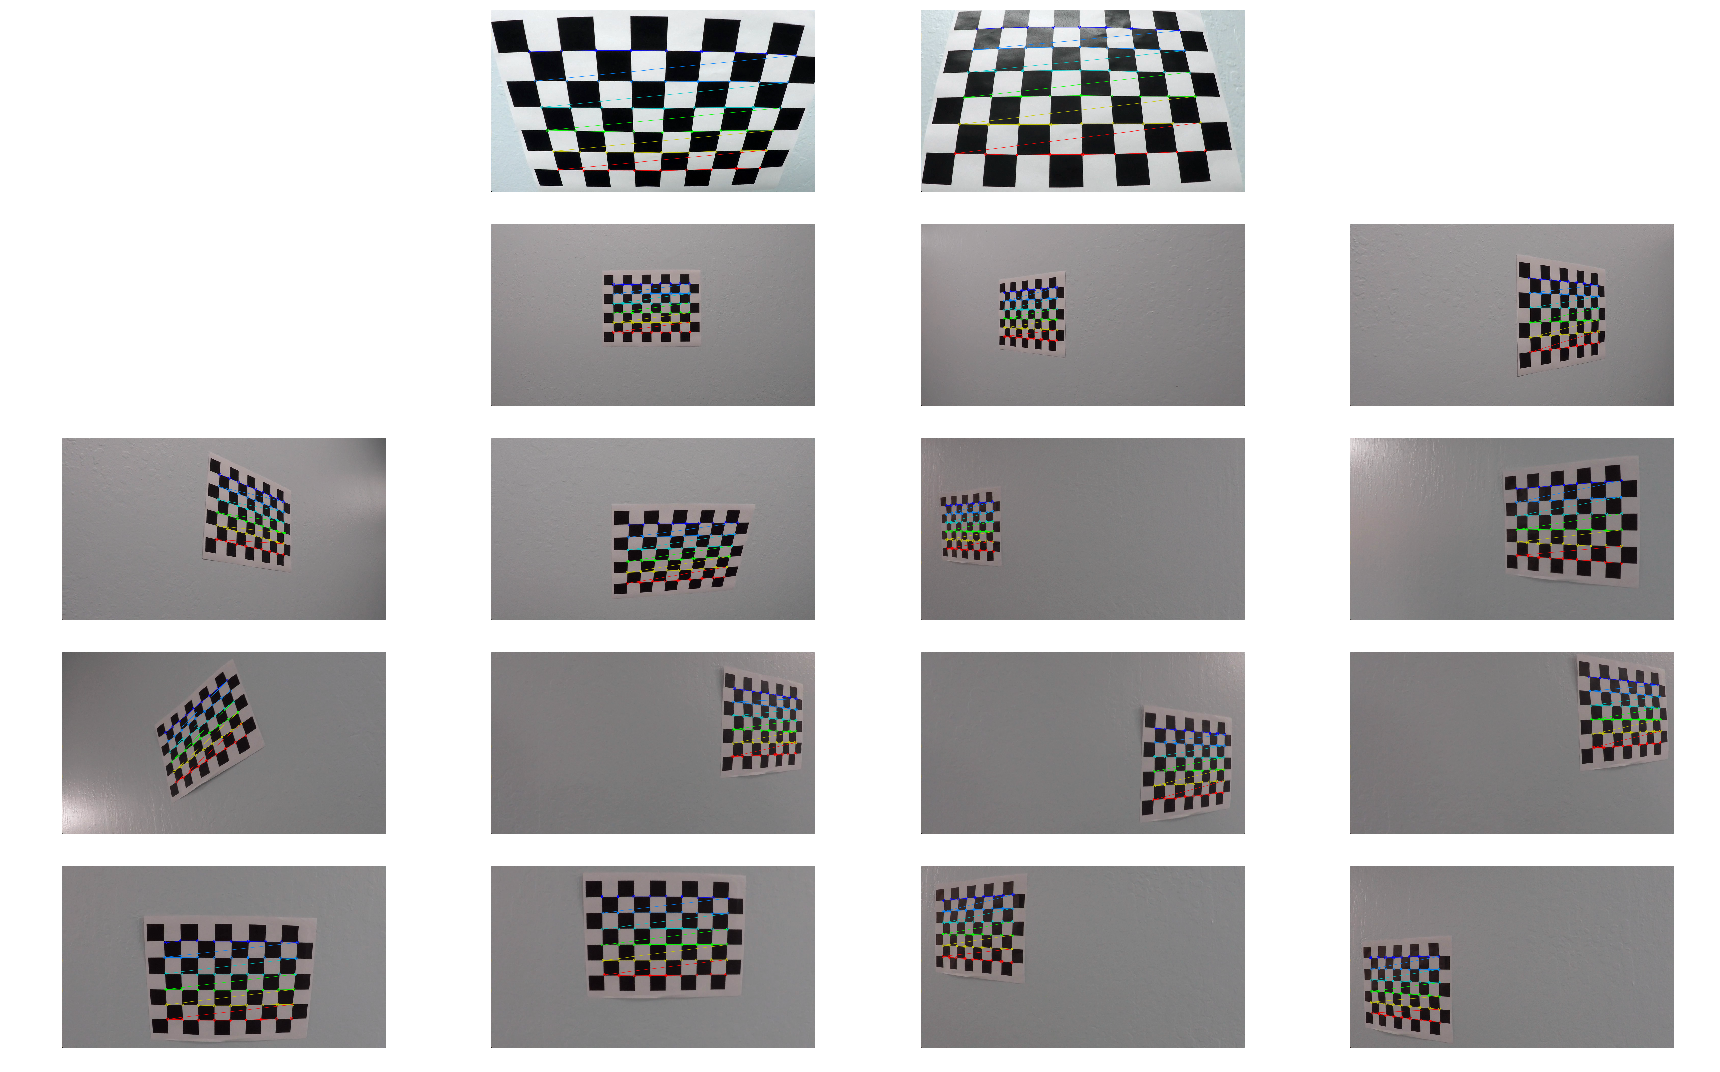

In [18]:
nx=9
ny=6
obj_val = np.zeros((ny*nx,3), dtype=np.float32)
obj_val[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_pts = []   # 3d points in real world space
img_pts = []   # 2d points in image plane.
cor_imgs = []  # images with found corners

# Make a list of calibration images
fig, ax_s = plt.subplots(5, 4, figsize=(24, 15))
fig.tight_layout()

img_sh = None
for i, xa in enumerate(ax_s.ravel()):
    xa.axis("off")
    img = cv2.imread(os.path.join(calib_directory, "calibration{}.jpg".format(i+1)))
    if img_sh == None:
        img_sh = img.shape[:2]
    gray_col = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_col, (nx, ny), None)
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    if ret:
        obj_pts.append(obj_val)
        img_pts.append(corners)
        cor_imgs.append(img)
        xa.imshow(img)

#### Determining the camera matrix

In [19]:
ret, camera_matrix, distortion_values, r_vecs, t_vecs = cv2.calibrateCamera(obj_pts, img_pts, img_sh[::-1], None, None)
with open(os.path.join(calib_directory, calib_file), "wb") as handle:
    np.save(handle, [camera_matrix, distortion_values])

print("Matrix of the camera")
print(camera_matrix)
print("\ncoefficients to determine distortion")
print(distortion_values)

Matrix of the camera
[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

coefficients to determine distortion
[[-0.24688507 -0.02373156 -0.00109831  0.00035107 -0.00259866]]


### Undisortion in the Image and Perfective Transformation of Images

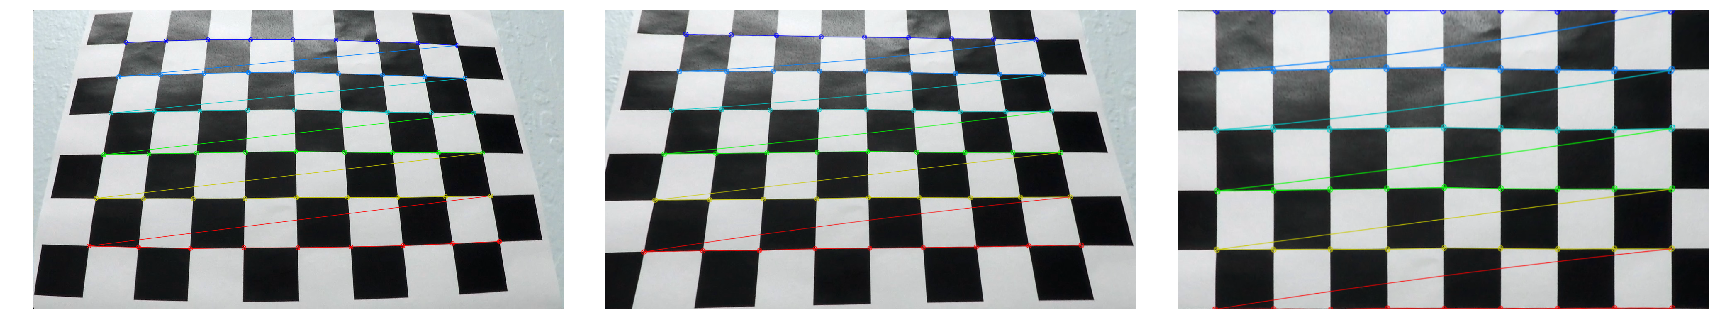

In [20]:
# checking for : Undistortion in images & Perspective Transform
fig, axs = plt.subplots(1, 3, figsize=(24, 10))
fig.tight_layout()

# to determine the undistort in an image, and perspective transform the image for which corners are found
for i, org_img in enumerate(cor_imgs):
    undist_img = cv2.undistort(org_img, camera_matrix, distortion_values)
    gray_1 = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
    ret, undist_cor = cv2.findChessboardCorners(gray_1, (nx, ny), None)

    if ret:
        # to collect values of 4 corners for src polygon
        l0 = undist_cor[0]    # top left
        l1 = undist_cor[nx-1] # top right
        l2 = undist_cor[-1]   # bottom right
        l3 = undist_cor[-nx]  # bottom left
        src_value = np.concatenate((l0, l1, l2, l3))

        # to define 4 destination points for perspective transform
        offset_v = 90
        rows, cols = img_sh
        dst_v = np.float32([[offset_v     , 0   ],
                          [cols-offset_v, 0   ],
                          [cols-offset_v, rows],
                          [offset_v     , rows]])

        M_v = cv2.getPerspectiveTransform(src_value, dst_v)
        warped_v = cv2.warpPerspective(undist_img, M_v, (cols,rows), flags=cv2.INTER_LINEAR)

        ax1, ax2, ax3 = axs
        ax1.imshow(org_img)
        ax1.axis("off")
        ax2.imshow(undist_img)
        ax2.axis("off")
        ax3.imshow(warped_v)
        ax3.axis("off")
        break

### Helper functions

In [21]:
def undist_img(img):
    """
    defined to Remove camera distortion from image
    """
    return cv2.undistort(img, camera_matrix, distortion_values)

def warp_img(img, src_v, dst_v, img_size):
    """
    to Compute the perspective transformation from a source to
    a destination and return the image with the perspective applied
    """
    M_v = cv2.getPerspectiveTransform(src_v, dst_v)
    return cv2.warpPerspective(img, M_v, img_size, flags=cv2.INTER_LINEAR)

def equalize_hsv(img):
    """
    to Convert image to HSV color space and perform Contrast Limited Adaptive
    Histogram Equalization on the V channel to help improve lane detection in shadows
    """
    h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    clahe_v = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return cv2.merge([h,s,clahe_v.apply(v)])

def filter_hsv_image(hsv_img,
                     yellow_dark=(15, 127, 127),
                     yellow_light=(25, 255, 255),
                     white_dark=(0, 0, 200),
                     white_light=(255, 30, 255)):
    """
    to Convert image to HSV color space and suppress any colors
    outside of the defined color ranges. Convert to binary img.
    """
    y_dark = np.array(yellow_dark, dtype=np.uint8)
    y_light = np.array(yellow_light, dtype=np.uint8)
    y_range = cv2.inRange(hsv_img, yellow_dark, yellow_light)

    w_dark = np.array(white_dark, dtype=np.uint8)
    w_light = np.array(white_light, dtype=np.uint8)
    w_range = cv2.inRange(hsv_img, white_dark, white_light)

    filtered = cv2.bitwise_and(hsv_img, hsv_img, mask=(y_range | w_range))
    return filtered[:,:,2] 

def sobel_filter(img, orient="x", ksize=3, thresh=(0, 255)):
    """
    to  Calculate directional gradient
    """
    if orient == "x":
        out = np.abs(cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize))
    else:
        out = np.abs(cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize))
    return np.uint8(255*out/np.max(out))

def image_binary_val(img, thresh=(0, 255)):
    """
    to Set pixel values between threshold values to 1 and all others to 0
    """
    out_binary_val = np.zeros_like(img)
    out_binary_val[(img > thresh[0]) & (img <= thresh[1])] = 1
    return out_binary_val

def base_x_vals(img):
    """
    to sum the columns and find the peak of the left and right halves of the histogram
    These will be the starting point for the left and right lines
    """
    y_mid = int(img.shape[0]/2)
    x_mid = int(img.shape[1]/2)
    histogram_mid = np.sum(img[y_mid:,:], axis=0)
    x_left = np.argmax(histogram_mid[:x_mid])
    x_right = np.argmax(histogram_mid[x_mid:]) + x_mid
    return x_left, x_right

def x_solve(curve_val, y_val):
    """
    to given a set of y-values, return the corresponding x-values,
    based on the polynomial coefficients contained in `curve_coeffs`
    """
    x_val = np.array([])
    fn = np.poly1d(curve_val)
    return fn(y_val)

def merge_x_y(x, y, invert=False):
    """
    to Re-combine the x and y values of points
    """
    merged_v = np.vstack([x, y]).T
    return np.flipud(merged_v) if invert else merged_v

def curve_radius_get(points, y_vals=360):
    """
    to rescale polynomial values to meters in x,y.
    Compute curve radius in meters.
    """
    y_vals *= y_pixel_dist
    A, B, C = np.polyfit(points[:,1]*y_pixel_dist, points[:,0]*x_pixel_dist, 2)

    # Calculate the radius of curvature at the given y value
    return (1 + (2*A*y_vals + B)**2)**1.5 / np.abs(2*A)

def lane_widths_get(left_x, right_x):
    """
    to Measure the distance in meters between the
    top and bottom values of the lane lines.
    """
    if len(left_x) == 0 or len(right_x) == 0:
        return 0., 0.
    top_width_x = (right_x[0] - left_x[0]) * x_pixel_dist
    bottom_width_x = (right_x[-1] - left_x[-1]) * x_pixel_dist
    return top_width_x, bottom_width_x

def lane_deviation(lane_center_v, img_width_v):
    """
    to Measure the amount (in centimeters) the center
    of the vehicle varies from the center of the lane
    """
    img_center_v = img_width_v / 2
    lane_deviation_v = lane_center_v - img_center_v
    return lane_deviation_v * x_pixel_dist * 100 

def curve_error_get(left_x, right_x):
    """
    Measure the difference between the 2 curves
    """
    if len(left_x) == 0 or len(right_x) == 0:
        return float('inf')

    # Compute the difference between the last x values of the left and right lanes
    diff_x = right_x[-1] - left_x[-1]

    # Translate the right lane so that the left and right lanes both have the same base x value
    right_x_prime = right_x - diff_x

    # Return sum of squared error to quantify the difference in the curves
    return np.sqrt(np.sum((left_x-right_x_prime)**2))

## Lane Detection

## class definition 

In [40]:
class lanedetector_get():
    def __init__(self,
                 show_diag=False,
                 print_to_frame=False,
                 buffer_s=5,
                 num_win_search=12,
                 search_win_marg=50,
                 min_pixels_search=50,
                 min_pixels_curve=50,
                 curve_width_line=25,
                 curve_thresh_error=1000.,
                 lane_error_width_thres=1.,
                 lane_min_width=2.5,
                 lane_max_width=4.5,
                 top_quad=.651,
                 lower_quad=0.154,
                 upper_quad=0.444,
                 projection_offset_quad=.28,
                 dark_yellow=(15, 60, 60),
                 light_yellow=(37, 255, 255),
                 dark_white=(0, 0, 200),
                 light_white=(255, 50, 255)):
        self.diag_image = None
        self.show_diag = show_diag
        self.print_to_frame = print_to_frame
        self.buffer_s = buffer_s
        self.left_buffer_lane = []
        self.right_buffer_lane = []
        self.left_radius_curve = 0.
        self.right_radius_curve = 0.
        self.curve_err = 0.
        self.curve_thresh_error = curve_thresh_error
        self.lane_top_width = 0.
        self.lane_bottom_width= 0.
        self.lane_error_width= 0.
        self.lane_deviate = 0.
        self.lane_error_width_thres = lane_error_width_thres
        self.lane_min_width = lane_min_width 
        self.lane_max_width = lane_max_width
        self.search_win_marg = search_win_marg
        self.num_win_search = num_win_search
        self.min_pixels_search = min_pixels_search
        self.min_pixels_curve = min_pixels_curve
        self.curve_width_line = curve_width_line
        self.top_quad = top_quad
        self.lower_quad = lower_quad
        self.upper_quad = upper_quad
        self.projection_offset_quad = projection_offset_quad
        self.dark_yellow = dark_yellow
        self.light_yellow = light_yellow
        self.dark_white = dark_white
        self.light_white = light_white

    def get_quad_angles(self, rows, cols):
        """
        to define 2 quadrangles for perspective transformation
        """
        # define pseudo tilted plane
        top = rows * self.top_quad
        lower_left  = cols * self.lower_quad
        upper_left  = cols * self.upper_quad
        lower_right = cols * (1.-self.lower_quad)
        upper_right = cols * (1.-self.upper_quad)
        src_vc = np.float32([[lower_left , rows],
                          [lower_right, rows],
                          [upper_right,  top],
                          [upper_left ,  top]])

        # define projected destination plane equivalent to bird's eye view of tilted plane
        top = 0.
        side_left = cols * self.projection_offset_quad
        side_right = cols * (1.-self.projection_offset_quad)
        dst_vc = np.float32([[side_left , rows],
                          [side_right, rows],
                          [side_right,  top],
                          [side_left ,  top]])

        return src_vc, dst_vc
    
    def buffer_line_add(self, line_spec, buffer_sz):
        """
        to push the current line onto the buffer and look whether the oldest line has to be dropped only 
        if there are more lines than what is the specified buffer size
        """
        buffer_sz.append(line_spec)
        return buffer_sz[-self.buffer_s:]
    
    def check_for_sanity(self, x_val_left, x_val_right):
        """
        to Only keep those lanes that meet the following criteria.
        """
        all_checks_pass = True
        
        if len(x_val_left) < self.min_pixels_curve or len(x_val_right) < self.min_pixels_curve:
            all_checks_pass = False

        # to Check  whether the lanes have similar curvature
        self.curve_err = curve_error_get(x_val_left, x_val_right)
        if self.curve_err > self.curve_thresh_error:
            all_checks_pass = False

        # to Check whether the lanes are roughly parallel
        self.lane_top_width, self.lane_bottom_width = lane_widths_get(x_val_left, x_val_right)
        self.lane_error_width = abs(self.lane_top_width - self.lane_bottom_width)
        if self.lane_error_width > self.lane_error_width_thres:
            all_checks_pass = False

        # to Check whether the lines  are separated by approximately the right distance horizontally
        if ((self.lane_top_width < self.lane_min_width) or
            (self.lane_top_width > self.lane_max_width) or
            (self.lane_bottom_width < self.lane_min_width) or
            (self.lane_bottom_width > self.lane_max_width)):
            all_checks_pass = False
        
        # to check whether all checks are pass
        return all_checks_pass

    def search_ahead(self, img, curve_val_cffs, x_val, hide_visualization=False):
        """
        to Search for points whether they are within a margin to the left and right of the given curve
        """
        y_val = np.linspace(0, img.shape[0]-1, x_val.shape[0])
        x_curve = x_solve(curve_val_cffs, y_val)
        
        if self.show_diag and not hide_visualization:
            line_img_val = np.zeros_like(self.diag_image)
            line_vc = merge_x_y(x_curve, y_val)
            cv2.polylines(line_img_val, [line_vc.astype(int)], False, (0,255,255), self.search_win_marg*2)
            cv2.addWeighted(self.diag_image, 1, line_img_val, 0.5, 0, self.diag_image)

        return ((x_val >= (x_curve-self.search_win_marg)) &
                (x_val < (x_curve+self.search_win_marg)))

    def window_search_sliding(self, img, initial_x, val_y, val_x, hide_visualization):
        rows, cols = img.shape
        
        # to check height of sliding windows
        win_height_val = int(rows/self.num_win_search)

        # to store lane pixel indices in a list
        indices_vc = []

        # to set the first x position to the initial x
        current_x = initial_x
        for y in reversed(range(0, rows, win_height_val)):
            # for window boundaries
            lower_y = y
            upper_y = y + win_height_val
            left_x = current_x - self.search_win_marg
            right_x = current_x + self.search_win_marg

            # to Draw the windows on the diagnostic image
            if self.show_diag and not hide_visualization:
                cv2.rectangle(self.diag_image, (left_x,lower_y), (right_x,upper_y), (0,200,200), 2)

            # to identify the nonzero pixels in x and y within the window
            found_indices_vc = ((val_y >= lower_y) & (val_y < upper_y) &
                             (val_x >= left_x) & (val_x < right_x)).nonzero()[0]

            # to append the indices to the lists
            indices_vc.append(found_indices_vc)

            # what if found > self.minimum_search_pixels, recenter next window on their mean position
            if len(found_indices_vc) >= self.min_pixels_search:
                current_x = int(np.mean(val_x[found_indices_vc]))

        # Concatenate and return the found indices
        return np.concatenate(indices_vc) 

    def lane_point_get(self, img, initial_x_val, y_val, x_val, lane_buffer_val, hide_visualization=False):
        """
        to find whether the points belong to the lane line.
        If lane buffer is empty, we try to use sliding window search, otherwise, just look search
        to look for points whether within a margin to the left and right of the buffered curve
        """
        if len(lane_buffer_val) > 1:
            curve_coeffs_val = lane_buffer_val[0]
            indices_vc = self.search_ahead(img, curve_coeffs_val, x_val, hide_visualization)
        else:
            indices_vc = self.window_search_sliding(img, initial_x_val, y_val, x_val,hide_visualization)

        # Extract x and y pixel coordinates
        points_vc = {"X": x_val[indices_vc], "Y": y_val[indices_vc]}
        
        # highlight the identified pixels
        if self.show_diag:
            self.diag_image[points_vc["Y"], points_vc["X"], :] = (0,190,0)
        
        return points_vc

    def curves_get_values(self, img, hide_visualization=False):
        """
        to Extract the values of the curves from the current frame, check  for sanity  and
        add the curve coefficients to the lane buffer or else discard
        to get the curve values and fall back to the buffered (previously approved) lanes
        """
        # to find the initial x values to start searching for curves
        x_left_base, x_right_base = base_x_vals(img)
        
        # get all the nonzero points in the image and find those
        # we think best represent the left and right lane lines
        y_nonzero, x_nonzero = img.nonzero()
        left_pts = self.lane_point_get(img, x_left_base, y_nonzero, x_nonzero, self.left_buffer_lane[1:],
                                          hide_visualization=hide_visualization)
        right_pts = self.lane_point_get(img, x_right_base, y_nonzero, x_nonzero, self.right_buffer_lane[1:],
                                           hide_visualization=hide_visualization)

        # to draw y values for  the curves
        rows, cols = img.shape[:2]
        y_val = np.linspace(0, rows-1, rows)
        
        # to fit an initial set of curve coefficients to the left and right sets of points
        x_left = np.array([])
        x_right = np.array([])
        if len(left_pts["X"]) > 1 and len(left_pts["Y"]) > 1:
            curve_coeffs_left_vc = np.polyfit(left_pts["Y"], left_pts["X"], 2)
            x_left = x_solve(curve_coeffs_left_vc, y_val)
            
        if len(right_pts["X"]) > 1 and len(right_pts["Y"]) > 1:
            curve_coeffs_right_vc = np.polyfit(right_pts["Y"], right_pts["X"], 2)
            x_right = x_solve(curve_coeffs_right_vc, y_val)    
        
        # to check if current x_coords pass the sanity check, to store curve coefficients in lane buffers
        if self. check_for_sanity(x_left, x_right):
            self.left_buffer_lane = self.buffer_line_add(curve_coeffs_left_vc, self.left_buffer_lane)
            self.right_buffer_lane = self.buffer_line_add(curve_coeffs_right_vc, self.right_buffer_lane)
        
        # to perform a recompute of curve coefficients by using the mean values
        # using lane buffers to draw the final curve
        mean_curve_coeffs_left = np.mean(self.left_buffer_lane, axis=0)
        mean_curve_coeffs_right = np.mean(self.right_buffer_lane, axis=0)

        # to solve for x in case of left and right lanes
        x_left = x_solve(mean_curve_coeffs_left, y_val)
        x_right = x_solve(mean_curve_coeffs_right, y_val)
        
        # to get the mean of the two curves  to compute the lane deviation
        mid_x = np.mean((x_left, x_right), axis=0)

        # to merge x and y coords for  left and right curves
        curve_left_vc = merge_x_y(x_left, y_val)
        curve_right_vc = merge_x_y(x_right, y_val, invert=True)

        # to get the curve midway between the lane lines
        curve_mid_vc = merge_x_y(mid_x, y_val)
        
        # to save the curve radii and lane deviation
        self.left_radius_curve = curve_radius_get(curve_left_vc)
        self.right_radius_curve = curve_radius_get(curve_right_vc)
        self.lane_deviate = lane_deviation(mid_x[-1], cols)

        if self.show_diag and not hide_visualization:
            cv2.polylines(self.diag_image, [curve_left_vc.astype(int)], False, (255,0,0), 5)
            cv2.polylines(self.diag_image, [curve_right_vc.astype(int)], False, (255,0,0), 5)
            cv2.polylines(self.diag_image, [curve_mid_vc.astype(int)], False, (0,190,190), 5)
            
            # vehicle center marker
            mid_vc = int(cols / 2)
            marker_vc = np.array(((mid_vc-30, rows   ),
                                 (mid_vc+30, rows   ),
                                 (   mid_vc, rows-30),
                                 (mid_vc-30, rows   )), dtype=int)
            marker_color_vc = (190,0,0) if abs(self.lane_deviate) > 30 else (0,100,0)
            cv2.fillPoly(self.diag_image, [marker_vc], marker_color_vc)

        return curve_left_vc, curve_right_vc
    
    def draw_curves_get(self, img):
        """
        to generate curve image to be overlayed atop the original image
        """
        curve_image_s = np.zeros(img.shape + (3,), dtype=np.uint8)

        curve_left_s, curve_right_s = self.curves_get_values(img)
        curve_poly_s = np.vstack((curve_left_s, curve_right_s))

        cv2.fillPoly(curve_image_s, [curve_poly_s.astype(int)], (0,255,255))
        cv2.polylines(curve_image_s, [curve_left_s.astype(int)], False, (255,255,0), self.curve_width_line)
        cv2.polylines(curve_image_s, [curve_right_s.astype(int)], False, (255,255,0), self.curve_width_line)
        return curve_image_s
    
    def print_info_get(self, img=np.array([]), pass_color=(0,100,0), fail_color=(190,0,0)):
        """
        to find the appropriate utility function to print relevant information on the output image
        """
        text_color_s = lambda n, thresh: fail_color if n > thresh else pass_color

        info = [("Left  Radius value: {:.1f} m".format(self.left_radius_curve), (0,0,0)),
                ("Right Radius value: {:.1f} m".format(self.right_radius_curve), (0,0,0)),
                ("Top Width value: {0:.3f} m".format(self.lane_top_width), (0,0,0)),
                ("Bottom Width value: {0:.3f} m".format(self.lane_bottom_width), (0,0,0)),
                ("Lane Center Deviation value: {0:.2f} cm".format(self.lane_deviate), (0,0,0)),
                ("Lane Width Error value: {:.3f}".format(self.lane_error_width), text_color_s(self.lane_error_width,
                                                                                      self.lane_error_width_thres)),
                ("Curve Match Error value: {0:.2f}".format(self.curve_err), text_color_s(self.curve_err,
                                                                                   self.curve_thresh_error)),]

        y_0, dy = 35, 40
        for i, line in enumerate(info):
            text_s, color_s = line
            if len(img) > 0:
                cv2.putText(img, text_s, (15, y_0 + i*dy), cv2.FONT_HERSHEY_SIMPLEX, 1, color_s, 2)
            else:
                print(text_s)
    
    def assemble_diagnostic_screen_get(self, img, warped, curves):
        """
        to view a few views of the current frame together for diagnostic purposes
        """
        right_s = np.vstack((warped, self.diag_image))
        right_c = cv2.resize(right_s, (640,720), interpolation=cv2.INTER_AREA)
        return np.hstack((img, right_c))
    
    def process_frame_get(self, img):
        """
        it is the main pipeline of the image processing algorithm
        """
        rows, cols = img.shape[:2]
        
        # to  get the quadrangles to use for the perspective transform
        src_quad_s, dst_quad_s = self.get_quad_angles(rows, cols)
        
        # to correct for camera lens distortion
        undistorted_s = undist_img(img)
        
        # to transform perspective to bird's eye view
        warped_s = warp_img(undistorted_s, src_quad_s, dst_quad_s, (cols,rows))
        
        # to filter image to exclude all values that is  not in yellow and white ranges
        hsv_s = equalize_hsv(warped_s)
        filtered_s = filter_hsv_image(hsv_s,
                                    yellow_dark=self.dark_yellow,
                                    yellow_light=self.light_yellow,
                                    white_dark=self.dark_white,
                                    white_light=self.light_white)
        binary_s = image_binary_val(filtered_s)

        # to create a diagnostic image if show_diagnostics is True
        if self.show_diag:
            self.diag_image = np.dstack((binary_s,binary_s,binary_s)) * 127
        
        # to get the rendered curve image to overlay
        curves_s = self.draw_curves_get(binary_s)
        
        # transform perspective of curve image to match original input image
        unwarped_curves_s = warp_img(curves_s, dst_quad_s, src_quad_s, (cols,rows))
        
        # overlay the curve image atop the original input image
        img = cv2.addWeighted(undistorted_s, 1, unwarped_curves_s, 0.5, 0)
        
        # if show_diagnostics is set to True, output a diagnostic image
        if self.show_diag:
            img = self.assemble_diagnostic_screen_get(img, warped_s, curves_s)
        
        # print relevant data onto the image
        if self.print_to_frame:
            self.print_info_get(img)
        return img

### Defining the quad angles for the perspective transformation

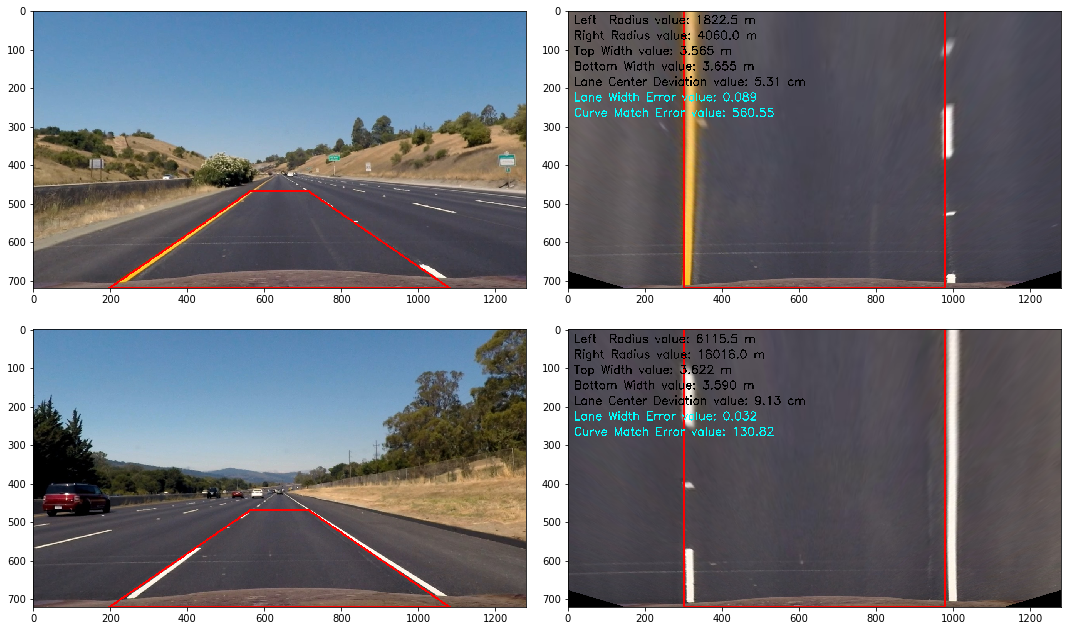

In [24]:
fig_1, axees = plt.subplots(2, 2, figsize=(15, 9))
fig_1.tight_layout()
for i, row in enumerate(axees):
    ld_vc = lanedetector_get(top_quad=.651,
                      lower_quad=0.154,
                      upper_quad=0.442,
                      projection_offset_quad=.235)
    ax_1, ax_2 = row
    image = mpimg.imread(os.path.join(test_img, "straight_lines{}.jpg".format(i+1)))
    rows, cols = image.shape[:2]
    src_c, dst_c = ld_vc.get_quad_angles(rows, cols)
    undistorted_c = undist_img(image)
    warped_c = warp_img(undistorted_c, src_c, dst_c, (cols,rows))
    
    # to look for the filtered, binary image for the purpose of calculating the curve values
    hsv_c = equalize_hsv(warped_c)
    filtered_c = filter_hsv_image(hsv_c,
                                yellow_dark=ld_vc.dark_yellow,
                                yellow_light=ld_vc.light_yellow,
                                white_dark=ld_vc.dark_white,
                                white_light=ld_vc.light_white)
    ld_vc.curves_get_values(image_binary_val(filtered_c))

    # to draw the source and destination quadrangles
    cv2.polylines(undistorted_c, [src_c.astype(int)], True, (255,), 4)
    cv2.polylines(warped_c, [dst_c.astype(int)], True, (255,), 4)

    ld_vc.print_info_get(warped_c, pass_color=(0,255,255))
    ax_1.imshow(undistorted_c)
    ax_2.imshow(warped_c)


### The input frames are transformed

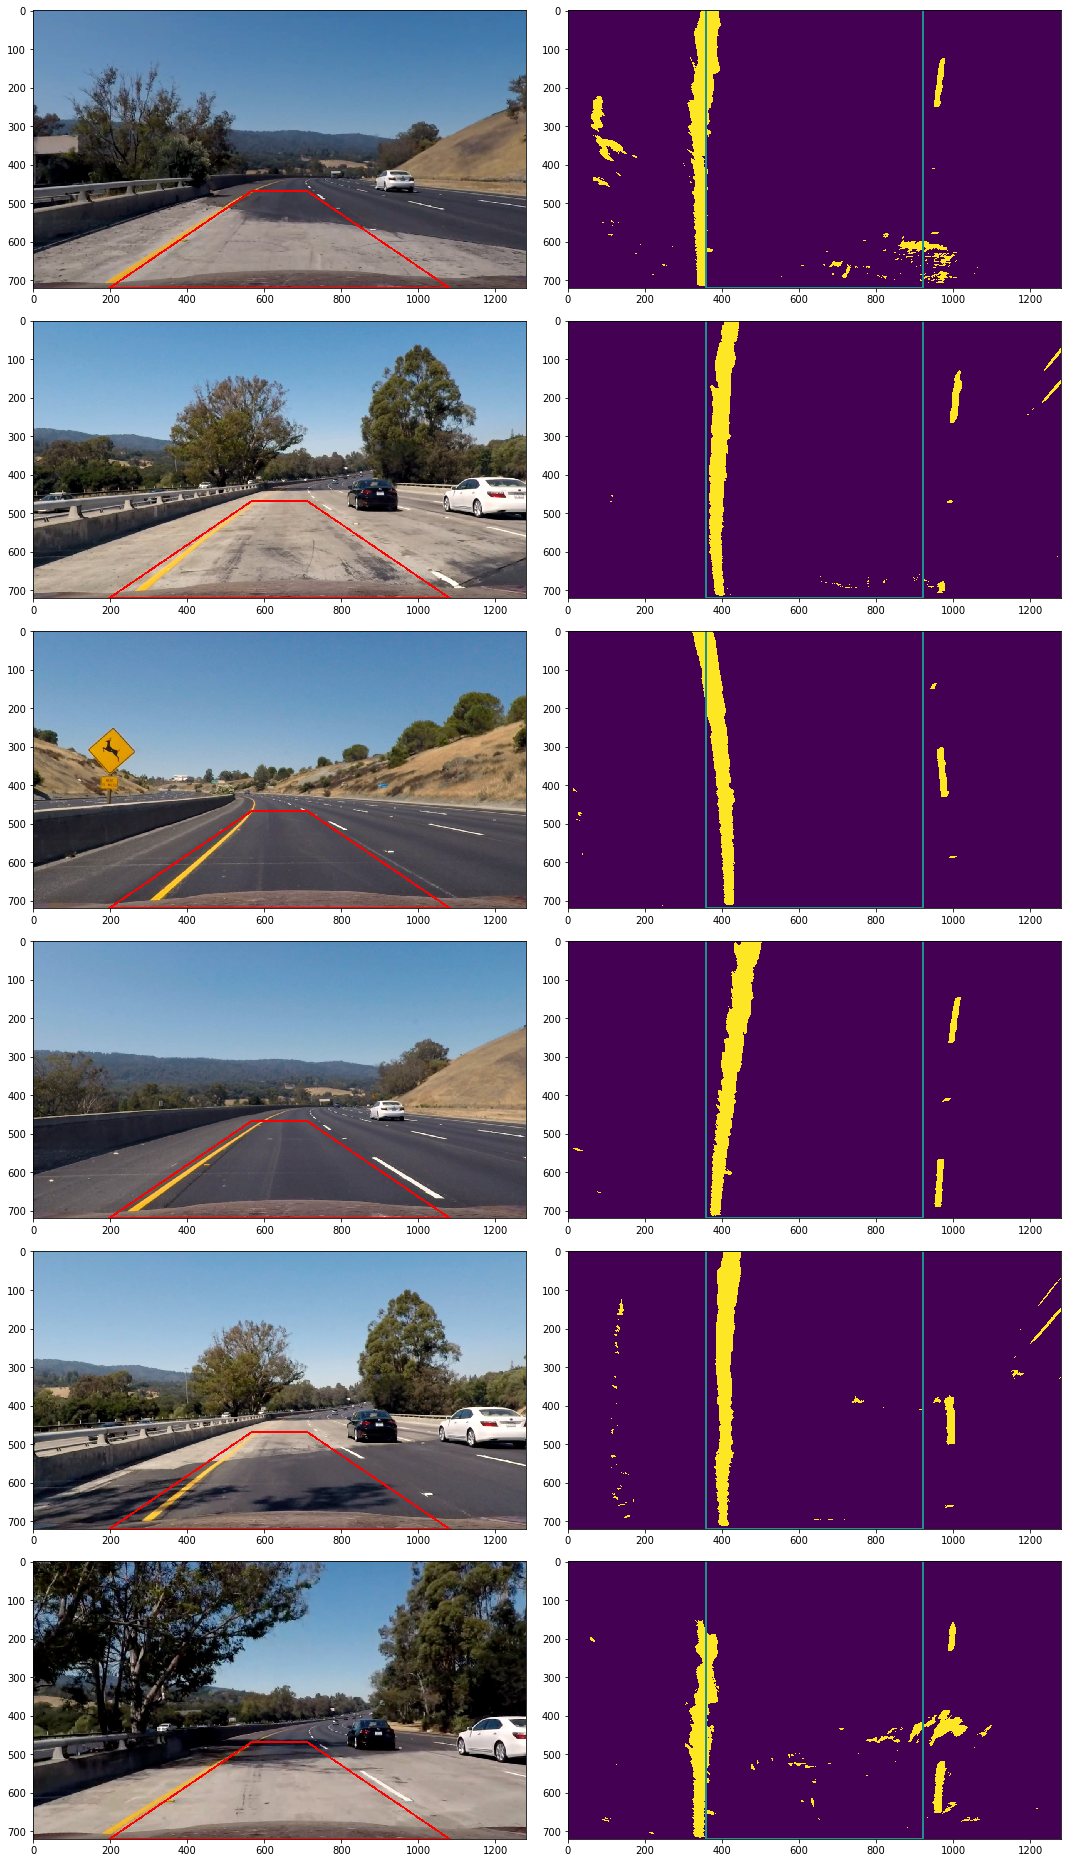

In [25]:
fig_2, axs_ee = plt.subplots(6, 2, figsize=(15, 26))
fig_2.tight_layout()
for i, row in enumerate(axs_ee):
    ld_sc = lanedetector_get(dark_yellow=(15, 70, 80),
                      light_yellow=(40, 255, 255),
                      dark_white=(0, 0, 200),
                      light_white=(255, 30, 255))
    ax1_1, ax2_2 = row
    image = mpimg.imread(os.path.join(test_img, "test{}.jpg".format(i)))
    rows, cols = image.shape[:2]
    src_v, dst_v = ld_sc.get_quad_angles(rows, cols)
    undistorted_v = undist_img(image)
    warped_v = warp_img(undistorted_v, src_v, dst_v, (cols,rows))
    hsv_v = equalize_hsv(warped_v)
    filtered_v = filter_hsv_image(hsv_v,
                                yellow_dark=ld_sc.dark_yellow,
                                yellow_light=ld_sc.light_yellow,
                                white_dark=ld_sc.dark_white,
                                white_light=ld_sc.light_white)
    binary_v = image_binary_val(filtered_v) * 2
    
    cv2.polylines(undistorted_v, [src_v.astype(int)], True, (255,), 4)
    cv2.polylines(binary_v, [dst_v.astype(int)], True, (1,), 4)
    ax1_1.imshow(undistorted_v)
    ax2_2.imshow(binary_v)


### To determine the x values (initial)

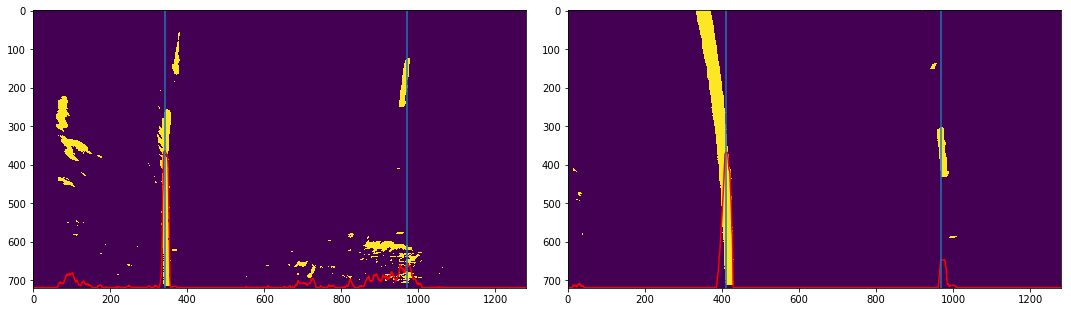

In [26]:
fig, axs_c = plt.subplots(1, 2, figsize=(15, 12))
fig.tight_layout()
for i, ax in enumerate(axs_c.ravel()):
    ld_c = lanedetector_get()
    image = mpimg.imread(os.path.join(test_img, "test{}.jpg".format((i) * 2)))
    rows, cols = image.shape[:2]
    src_c, dst_c = ld_c.get_quad_angles(rows, cols)
    undistorted_c = undist_img(image)
    warped_c = warp_img(undistorted_c, src_c, dst_c, (cols,rows))

    hsv_c = equalize_hsv(warped_c)
    binary_c = image_binary_val(filter_hsv_image(hsv_c))

    mid_yval = int(img.shape[0]/2)
    mid_xval = int(img.shape[1]/2)
    histogram_c = np.sum(binary_c[mid_yval:,:], axis=0)
    x_left_initial = np.argmax(histogram_c[:mid_xval])
    x_right_initial = np.argmax(histogram_c[mid_xval:]) + mid_xval

    x_val = np.linspace(0, img.shape[1]-1, img.shape[1])
    y_val = img.shape[0] - 1 - histogram_c
    
    ax.imshow(binary_c)
    ax.plot(x_val, y_val, color='r')
    ax.axvline(x=x_left_initial)
    ax.axvline(x=x_right_initial)

### to visualize through the sliding window 

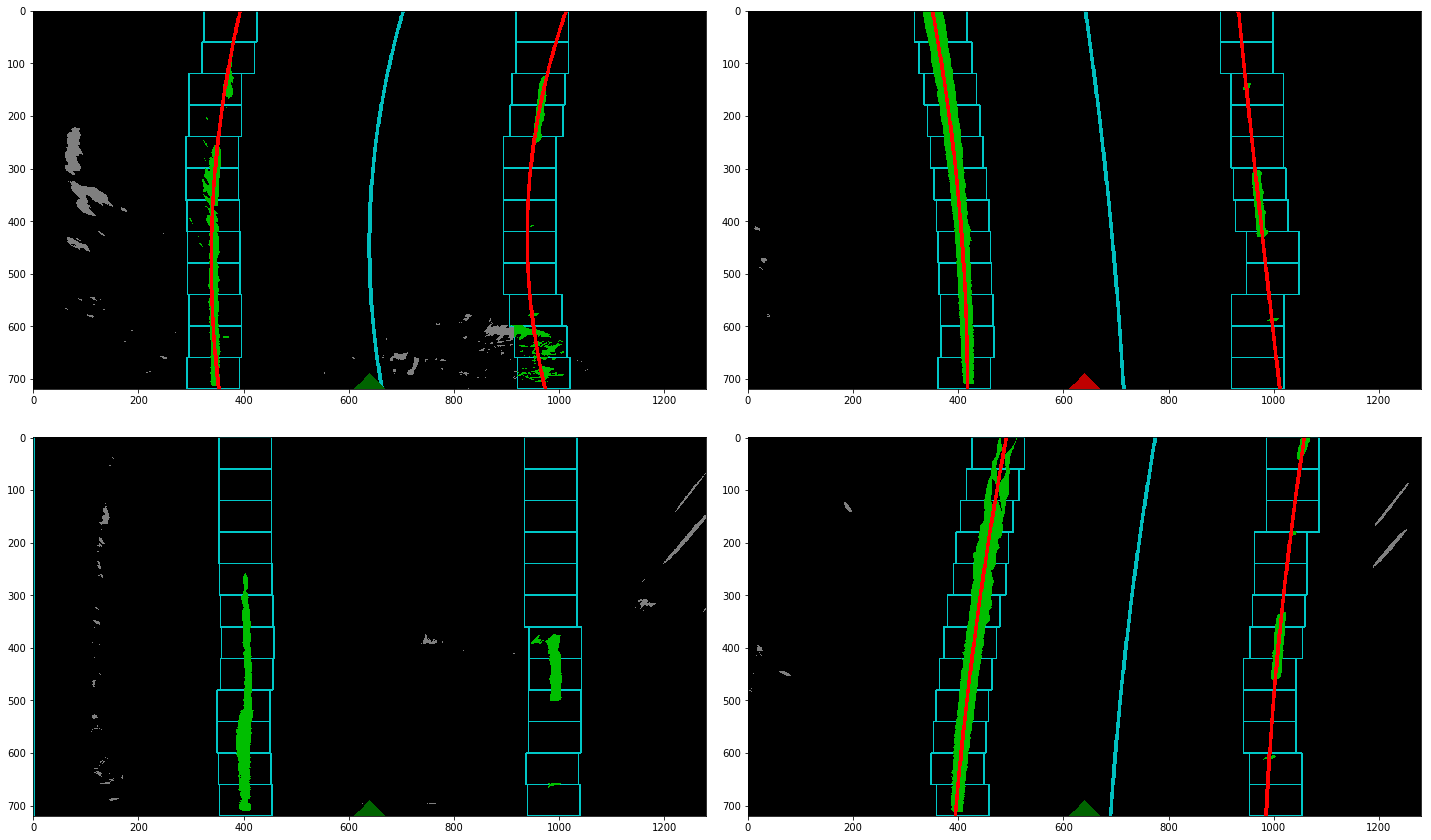

In [27]:
fig, axs_d = plt.subplots(2, 2, figsize=(20, 12))
fig.tight_layout()
for i, ax in enumerate(axs_d.ravel()):
    ld_d = lanedetector_get(show_diag=True,
                      dark_yellow=(15, 90, 80),
                      light_yellow=(37, 255, 255),
                      dark_white=(0, 0, 200),
                      light_white=(255, 30, 255))
    image = mpimg.imread(os.path.join(test_img, "test{}.jpg".format((i)*2)))
    rows, cols = image.shape[:2]
    src_d, dst_d = ld_d.get_quad_angles(rows, cols)
    undistorted_d = undist_img(image)
    warped_d = warp_img(undistorted_d, src_d, dst_d, (cols,rows))
    hsv_d = equalize_hsv(warped_d)
    filtered_d = filter_hsv_image(hsv_d,
                            yellow_dark=ld_d.dark_yellow,
                            yellow_light=ld_d.light_yellow,
                            white_dark=ld_d.dark_white,
                            white_light=ld_d.light_white)
    binary_d = image_binary_val(filter_hsv_image(hsv_d))

    ld_d.diag_image = np.dstack((binary_d,binary_d,binary_d)) * 127
    ld_d.curves_get_values(binary_d)
    ax.imshow(ld_d.diag_image)

### To visualize the look ahead search 

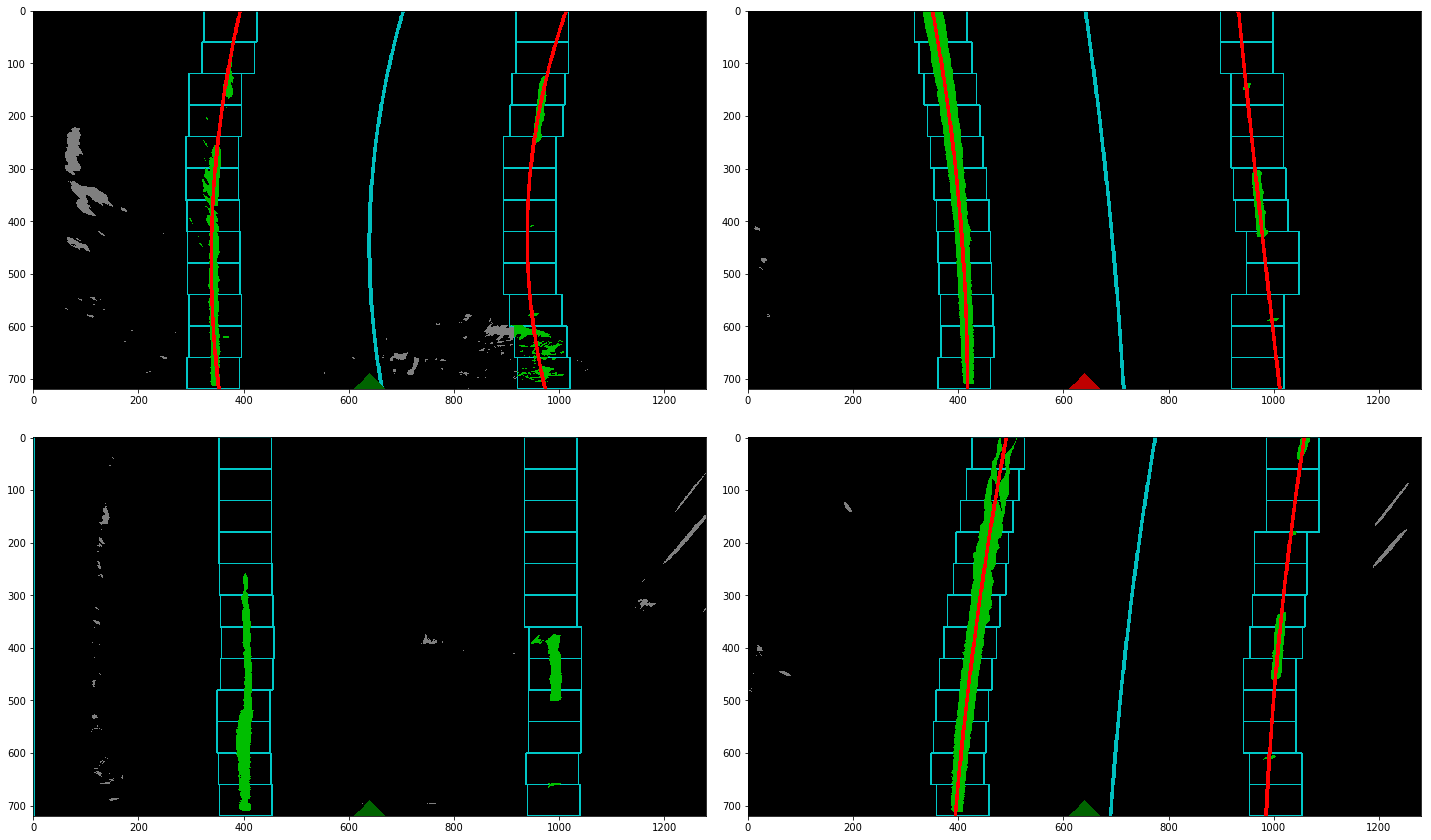

In [28]:
fig, axs_f = plt.subplots(2, 2, figsize=(20, 12))
fig.tight_layout()
for i, ax in enumerate(axs_f.ravel()):
    ld_f = lanedetector_get(show_diag=True)
    image = mpimg.imread(os.path.join(test_img, "test{}.jpg".format(i*2)))
    rows, cols = image.shape[:2]
    src_f, dst_f = ld_f.get_quad_angles(rows, cols)
    undistorted_f = undist_img(image)
    warped_f = warp_img(undistorted_f, src_f, dst_f, (cols,rows))
    hsv_f = equalize_hsv(warped_f)
    binary_f = image_binary_val(filter_hsv_image(hsv_f))

    ld_f.diag_image = np.dstack((binary_f,binary_f,binary_f)) * 127
    ld_f.curves_get_values(binary_f, hide_visualization=True)
    ld_f.curves_get_values(binary_f)
    ax.imshow(ld_f.diag_image) 

### diagonosing the examples to test the alogorithms

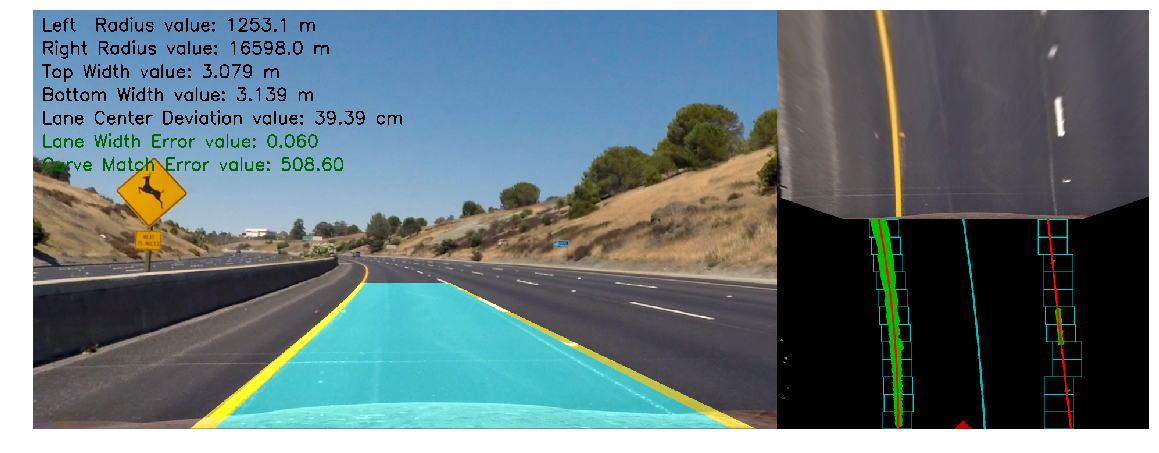

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = mpimg.imread(os.path.join(test_img, "test{}.jpg".format(2)))
ld = lanedetector_get(show_diag=True, print_to_frame=True)
ax.axis("off")
ax.imshow(ld.process_frame_get(im))

### processing the video

In [36]:
ld = lanedetector_get(show_diag=False, print_to_frame=True, buffer_s=3)

input_1 = os.path.join(input_vid, "project_video.mp4")
output_1 = os.path.join(out_vid, "project_video_process.mp4")
clip_1 = VideoFileClip(input_1)
project_clip = clip_1.fl_image(ld.process_frame_get)
%time project_clip.write_videofile(output_1, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_process.mp4
[MoviePy] Writing video output_videos/project_video_process.mp4


100%|█████████▉| 1260/1261 [03:51<00:00,  5.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_process.mp4 

CPU times: user 1min 48s, sys: 2.72 s, total: 1min 50s
Wall time: 3min 54s


In [37]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_1))

### Analysing the video 

In [41]:
ld = lanedetector_get(show_diag=True, print_to_frame=True,)

input_2 = os.path.join(input_vid, "project_video.mp4")
output_2 = os.path.join(out_vid, "project_video_diagnostic.mp4")
clip_2 = VideoFileClip(input_2)
project_clip = clip_2.fl_image(ld.process_frame_get)
%time project_clip.write_videofile(output_2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_diagnostic.mp4
[MoviePy] Writing video output_videos/project_video_diagnostic.mp4



 24%|██▍       | 303/1261 [03:06<09:54,  1.61it/s]


 48%|████▊     | 605/1261 [06:31<07:00,  1.56it/s]


 72%|███████▏  | 907/1261 [09:48<03:52,  1.52it/s]


 96%|█████████▌| 1205/1261 [13:35<00:38,  1.44it/s]


100%|█████████▉| 1260/1261 [14:14<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_diagnostic.mp4 

CPU times: user 11min 20s, sys: 3.9 s, total: 11min 24s
Wall time: 14min 18s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_2))

### Challenging the Video 

In [44]:
ld = lanedetector_get(show_diag=True,
                  print_to_frame=True,
                  curve_thresh_error=1500.,
                  lane_error_width_thres=1.,
                  lane_min_width=2.5,
                  lane_max_width=4.5,
                  top_quad=.69,
                  lower_quad=0.154,
                  upper_quad=0.429,
                  projection_offset_quad=.213)

input_3 = os.path.join(input_vid, "challenge_video.mp4")
output_3 = os.path.join(out_vid, "challenge_video_process.mp4")
clip_3 = VideoFileClip(input_3)
project_clip = clip_3.fl_image(ld.process_frame_get)
%time project_clip.write_videofile(output_3, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_process.mp4
[MoviePy] Writing video output_videos/challenge_video_process.mp4



100%|█████████▉| 484/485 [04:11<00:00,  1.87it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/moviepy/video/io/ffmpeg_reader.py:132: UserWarning: Warning: in file input_videos/challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 485/485 [04:11<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_process.mp4 

CPU times: user 3min 12s, sys: 1.5 s, total: 3min 13s
Wall time: 4min 15s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_3))